# Task 3. Algorithms for unconstrained nonlinear optimization. First- and second- order methods

In [1]:
import matplotlib.pyplot as plt
from collections.abc import Callable
from functools import partial
import numpy as np
import pandas as pd

In [2]:
import json

with open('./../2/points.json') as file:
    content = json.loads(file.read())
    alpha = content['alpha']
    beta = content['beta']
    y = content['y']

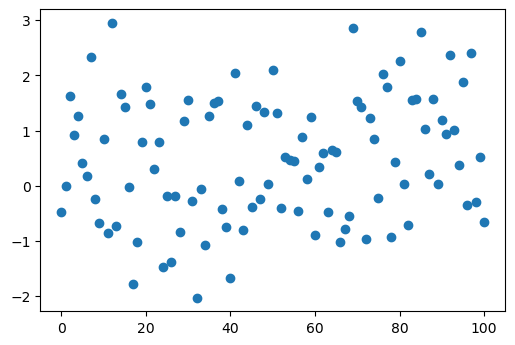

In [3]:
n = 101

x = [x_k for x_k in range(n)]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

In [4]:
def linear(x: float, a: float, b: float) -> float:
    return a * x + b

def rational(x: float, a: float, b: float) -> float:
    return a / (1 + b * x)

In [5]:
def least_squares(args, fn: Callable):
    return sum([np.power(fn(x[i], args[0], args[1]) - y[i], 2) for i in range(n)])

In [6]:
from scipy.optimize import minimize

def gradient_descent(function, args, x0, epsilon):
    return minimize(
        function,
        x0=x0,
        method='BFGS',
        args=(args,),
        tol=epsilon
    )

gd_result=gradient_descent(least_squares, linear, (0, 0), 0.001)

gd_a = gd_result.x[0]
gd_b = gd_result.x[1]

gd_result

      fun: 124.02109481374161
 hess_inv: array([[ 2.24231762e-04, -1.49232999e-02],
       [-1.49232999e-02,  9.99779479e-01]])
      jac: array([ 2.13623047e-04, -9.53674316e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([0.0061822 , 0.17318067])

In [7]:
def conjugate_gradient(fn: Callable, args, x0, epsilon: float = 0.001):
    return minimize(
        fn,
        x0=x0,
        method='CG',
        args=(args,),
        tol=epsilon
    )

In [8]:
cg_result = conjugate_gradient(least_squares, linear, (0, 0))
cg_a = cg_result.x[0]
cg_b = cg_result.x[1]

In [9]:
from autograd import jacobian

def newtons_method(fn: Callable, args, x0, epsilon: float = 0.001):
    return minimize(
        fn,
        x0=x0,
        method='Newton-CG',
        args=(args,),
        jac=jacobian(fn),
        tol=epsilon
    )

In [10]:
nm_result = newtons_method(least_squares, linear, (0, 0))
nm_a = nm_result.x[0]
nm_b = nm_result.x[1]

In [11]:
from scipy.optimize import curve_fit

def levenberg_marquardt(fn: Callable, x: list[float], y: list[float]):
    return curve_fit(
        fn,
        xdata=x,
        ydata=y,
        method='lm'
    )

In [12]:
lm_result = levenberg_marquardt(linear, x, y)

lm_a = lm_result[0][0]
lm_b = lm_result[0][1]

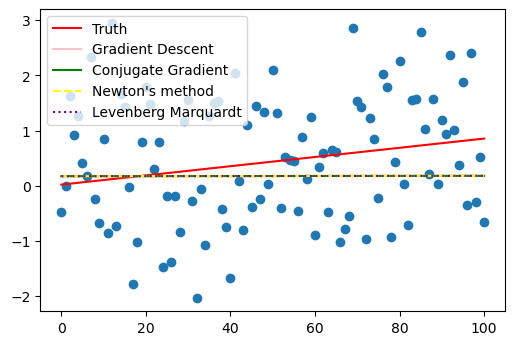

In [13]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
    
ax.scatter(range(n), y, zorder=1)
ax.plot(range(n), [linear(x / n, alpha, beta) for x in range(n)], color='red', label="Truth")
ax.plot(range(n), [linear(x / n, gd_a, gd_b) for x in range(n)], color='pink', label='Gradient Descent')
ax.plot(range(n), [linear(x / n, cg_a, cg_b) for x in range(n)], color='green', label='Conjugate Gradient')
ax.plot(range(n), [linear(x / n, nm_a, nm_b) for x in range(n)], color='yellow', linestyle='dashed', label='Newton\'s method')
ax.plot(range(n), [linear(x / n, lm_a, lm_b) for x in range(n)], color='purple', linestyle='dotted', label='Levenberg Marquardt')
ax.legend(loc='upper left')

In [14]:
pd.DataFrame(
    [
        ['Gradient Descent', gd_a, gd_b, gd_result.nit, gd_result.nfev],
        ['Conjugate Gradient', cg_a, cg_b, cg_result.nit, cg_result.nfev],
        ['Newton\'s method', nm_a, nm_b, nm_result.nit, nm_result.nfev],
        ['Levenberg-Marquardt', lm_a, lm_b, 'n/a', 'n/a']
    ],
    columns=['Method', '$a_{min}$', '$b_{min}$', 'Iterations', 'F-Calculations']
)

,Method,$a_{min}$,$b_{min}$,Iterations,F-Calculations
0,Gradient Descent,0.006182,0.173181,2,15
1,Conjugate Gradient,0.006182,0.173181,2,15
2,Newton's method,0.006182,0.173179,2,24
3,Levenberg-Marquardt,0.006182,0.173179,n/a,n/a


In [15]:
def least_squares_rational_gradient(a, b) -> (float, float):
    temp_a = []
    temp_b = []
    for k in range(n):
        x = (k / n)
        y_i = (y[k])

        a_denominator = (1 + b * x) ** 2
        temp_a.append(
            - ((2 * x * b * y_i) / a_denominator)
            + (2 * a / a_denominator)
            - (2 * y_i / a_denominator)
        )

        temp_b.append(
            -(2 * a * x * (a - y_i - x * b * y_i))
            / ((b * x + 1) ** 3)
        )
    df_da = sum(temp_a)
    df_db = sum(temp_b)
    
    return df_da, df_db

least_squares_rational = lambda a, b: sum([(rational(k / n, a, b) - x[k]) ** 2 for k in range(n)])

gd_result = gradient_descent(least_squares, rational, (0, 0), 0.001)
gd_a = gd_result.x[0]
gd_b = gd_result.x[1]

gd_result

      fun: 123.35306492346665
 hess_inv: array([[4.36475005e-03, 6.04534041e-05],
       [6.04534041e-05, 1.24819127e-06]])
      jac: array([-9.53674316e-07,  3.13758850e-04])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([ 0.27790985, -0.00713208])

In [16]:
cg_result = conjugate_gradient(least_squares, rational, (0, 0))
cg_a = cg_result.x[0]
cg_b = cg_result.x[1]

In [17]:
nm_result = newtons_method(least_squares, rational, (0, 0))
nm_a = nm_result.x[0]
nm_b = nm_result.x[1]

In [18]:
lm_result = levenberg_marquardt(rational, x, y)

lm_a = lm_result[0][0]
lm_b = lm_result[0][1]

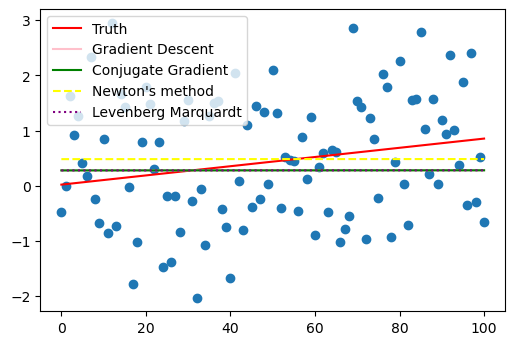

In [19]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
    
ax.scatter(range(n), y, zorder=1)
ax.plot(range(n), [linear(x / n, alpha, beta) for x in range(n)], color='red', label="Truth")
ax.plot(range(n), [rational(x / n, gd_a, gd_b) for x in range(n)], color='pink', label='Gradient Descent')
ax.plot(range(n), [rational(x / n, cg_a, cg_b) for x in range(n)], color='green', label='Conjugate Gradient')
ax.plot(range(n), [rational(x / n, nm_a, nm_b) for x in range(n)], color='yellow', linestyle='dashed', label='Newton\'s method')
ax.plot(range(n), [rational(x / n, lm_a, lm_b) for x in range(n)], color='purple', linestyle='dotted', label='Levenberg Marquardt')
ax.legend(loc='upper left')

In [20]:
pd.DataFrame(
    [
        ['Gradient Descent', gd_a, gd_b, gd_result.nit, gd_result.nfev],
        ['Conjugate Gradient', cg_a, cg_b, cg_result.nit, cg_result.nfev],
        ['Newton\'s method', nm_a, nm_b, nm_result.nit, nm_result.nfev],
        ['Levenberg-Marquardt', lm_a, lm_b, 'n/a', 'n/a']
    ],
    columns=['Method', '$a_{min}$', '$b_{min}$', 'Iterations', 'F-Calculations']
)

,Method,$a_{min}$,$b_{min}$,Iterations,F-Calculations
0,Gradient Descent,0.277910,-0.007132,12,54
1,Conjugate Gradient,0.277895,-0.007132,14,214
2,Newton's method,0.482233,-0.003426,3,8
3,Levenberg-Marquardt,0.277893,-0.007132,n/a,n/a
